# Задание, оцениваемое сокурсниками: Анализ данных в задаче кредитного скоринга

In [1]:
import numpy as np
import pandas as pd
import statsmodels
import scipy as sc
from statsmodels.stats.weightstats import *
from pandas.tools.plotting import scatter_matrix
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('credit_card_default_analysis.csv', index_col=0)
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Вспомогательные функции

In [4]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [5]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [21]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [69]:
def proportions_confint_diff_ind(a1, n1, a2, n2, alpha = 0.05):    
    z = sc.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(a1) / n1
    p2 = float(a2) / n2
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    
    return (left_boundary, right_boundary)

In [71]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - sc.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return sc.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - sc.stats.norm.cdf(z_stat)

In [72]:
def proportions_diff_z_stat_ind(a, n1, b, n2):        
    p1 = float(a) / n1
    p2 = float(b) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

## 1. Размер кредитного лимита (LIMIT_BAL)

 В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [22]:
data_def_0 = data[data.default == 0]
data_def_1 = data[data.default == 1]

In [23]:
data_def_0.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,23364.0,178099.726074,131628.359660,10000.0,70000.00,150000.0,250000.00,1000000.0
SEX,23364.0,1.614150,0.486806,1.0,1.00,2.0,2.00,2.0
EDUCATION,23364.0,1.841337,0.806780,0.0,1.00,2.0,2.00,6.0
MARRIAGE,23364.0,1.558637,0.520794,0.0,1.00,2.0,2.00,3.0
AGE,23364.0,35.417266,9.077355,21.0,28.00,34.0,41.00,79.0
PAY_0,23364.0,0.196242,0.548516,0.0,0.00,0.0,0.00,8.0
PAY_2,23364.0,0.180277,0.619238,0.0,0.00,0.0,0.00,8.0
PAY_3,23364.0,0.183145,0.617461,0.0,0.00,0.0,0.00,8.0
PAY_4,23364.0,0.149632,0.569859,0.0,0.00,0.0,0.00,8.0
PAY_5,23364.0,0.121726,0.518453,0.0,0.00,0.0,0.00,7.0


In [24]:
data_def_1.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,6636.0,130109.656420,115378.540571,10000.0,50000.00,90000.0,200000.00,740000.0
SEX,6636.0,1.567058,0.495520,1.0,1.00,2.0,2.00,2.0
EDUCATION,6636.0,1.894665,0.728096,1.0,1.00,2.0,2.00,6.0
MARRIAGE,6636.0,1.528029,0.525433,0.0,1.00,2.0,2.00,3.0
AGE,6636.0,35.725738,9.693438,21.0,28.00,34.0,42.00,75.0
PAY_0,6636.0,0.921941,1.070504,0.0,0.00,1.0,2.00,8.0
PAY_2,6636.0,0.812086,1.115802,0.0,0.00,0.0,2.00,7.0
PAY_3,6636.0,0.729807,1.118357,0.0,0.00,0.0,2.00,8.0
PAY_4,6636.0,0.643008,1.134064,0.0,0.00,0.0,2.00,8.0
PAY_5,6636.0,0.572785,1.106387,0.0,0.00,0.0,0.00,8.0


### Посмотрим распределение на LIMIT_BAL графике

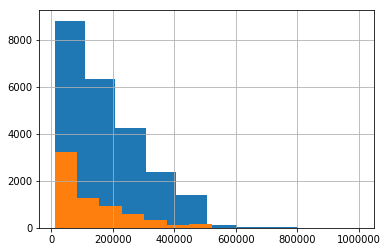

In [244]:
data_def_0['LIMIT_BAL'].hist()
data_def_1['LIMIT_BAL'].hist()

### a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

In [247]:
np.random.seed(0)
data_def_0_median_scores = map(np.median, get_bootstrap_samples(data_def_0['LIMIT_BAL'].values, 1000))
data_def_1_median_scores = map(np.median, get_bootstrap_samples(data_def_1['LIMIT_BAL'].values, 1000))
delta_median_scores = map(lambda x: x[0] - x[1], zip(data_def_0_median_scores, data_def_1_median_scores))
print u"95% доверительный интервал разности медиан:",  stat_intervals(delta_median_scores, 0.05)

95% доверительный интервал разности медиан: [60000. 70000.]


95%-ый доверительный интервал для разности медиан не содержит 0, нулевая гипотеза отвергается в пользу альтернативы о неравенстве медиан.

###  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

Проверим перестановочным критерием равенстро распределений

In [29]:
print "p-value: %f" % permutation_test(data_def_0['LIMIT_BAL'].values, data_def_1['LIMIT_BAL'].values, max_permutations = 10000)

p-value: 0.000100


P-value - мало, значит гипотезу о равенстве распределений отвергаем. С практической точки зрения результат не имеет большого значения.

## Пол (SEX)

Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.

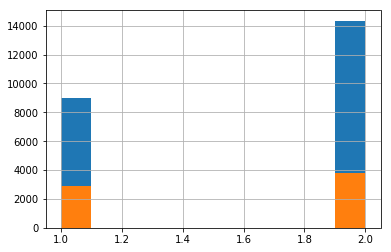

In [89]:
data_def_0['SEX'].hist()
data_def_1['SEX'].hist()

In [111]:
data.pivot_table(columns=['SEX'], values=['LIMIT_BAL'],index=['default'], aggfunc=len)

LIMIT_BAL       
SEX             1      2
default                 
0            9015  14349
1            2873   3763

Гендреный став, вернувших долг отличается, в группе не вернувших долг состав более сбалансированый.

Проверим теорию что гендреный состав групп не отличается друг от друга. Посчитаем количество женщин в группах. Используем доверительных для двух независимых выборок

In [78]:
count_def0 = float(len(data_def_0))
count_def1 = float(len(data_def_1))
count_wmn_0 =float(len(data_def_0[data_def_0['SEX']==1]))
count_wmn_1 = float(len(data_def_1[data_def_1['SEX']==1]))
print "confidence interval: [%f, %f]" % proportions_confint_diff_ind(count_wmn_0, count_def0, count_wmn_1, count_def1)

confidence interval: [-0.060548, -0.033635]


Интервал не содержит 0, теория о равенстве распрделений отвергается. Составы групп вернувших и не вернувших долг отличаются

Проверим гипотезу равенства состава групп чрез Z критерий

In [87]:
proportions_diff_z_test(proportions_diff_z_stat_ind(count_wmn_0, count_def0, count_wmn_1, count_def1))

4.472866521609831e-12

P-value  меньше 0.05 теорию о равенстве распределенй в группах отвергаем

## Образование (EDUCATION)

Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг.

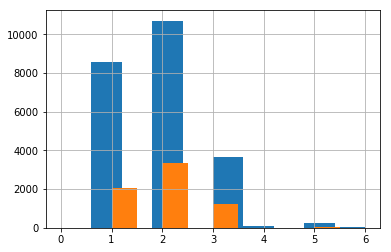

In [90]:
# 1- 'PhD', 2 -'MS', 3 - 'BS', 4 - 'School', 5 -'Elementary', 6 -'Other', 7- 'N/A'

data_def_0['EDUCATION'].hist()
data_def_1['EDUCATION'].hist()

In [112]:
type(data_def_0['EDUCATION'].value_counts())

pandas.core.series.Series

Проверим гипотезу что образование не влияет на возврат кредита

In [188]:
pv = data.pivot_table(columns=['default'], values=['LIMIT_BAL'],index=['EDUCATION'], aggfunc=len)
pv = pv.fillna(0)
pv

LIMIT_BAL        
default           0       1
EDUCATION                  
0              14.0     0.0
1            8549.0  2036.0
2           10700.0  3330.0
3            3680.0  1237.0
4             116.0     7.0
5             262.0    18.0
6              43.0     8.0

Возьмем для проверки Хи квадрат

In [224]:
data_ed =[]
for i in range(0,7):
    data_ed.append([pv.iloc[i][0],pv.iloc[i][1]])

chi2, p, dof, expected = sc.stats.chi2_contingency(data_ed)
p

1.2332626245415605e-32

P-value  знаительно меньше 0, гипотеза что образование не влияет на возврат долга отвергается. Образование влияет на возврат долга

Составим таблицу разностей ожидаемых значений и реальных

In [230]:
educ_real = np.array(data_ed)
pd.DataFrame( np.around(educ_real - expected), columns=(u'Кредит вернули',u'Кредит не вернули'))

,Кредит вернули,Кредит не вернули
0,3.0,-3.0
1,305.0,-305.0
2,-227.0,227.0
3,-149.0,149.0
4,20.0,-20.0
5,44.0,-44.0
6,3.0,-3.0


Для приведения таблицы к одному масштабу - можно каждую колонку поделить на количество клиентов в каждой группе. При наличии образования "доктор" (0) наибольшая вероятность что долг вернут, а при наличии образования "Бакалавр"(2), самый блоьшаявероятность что долг не вернут

## Семейное положение (MARRIAGE):

Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

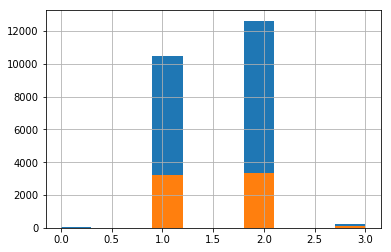

In [233]:
#  (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
data_def_0['MARRIAGE'].hist()
data_def_1['MARRIAGE'].hist()

In [234]:
pv = data.pivot_table(columns=['default'], values=['LIMIT_BAL'],index=['MARRIAGE'], aggfunc=len)
pv = pv.fillna(0)
pv

LIMIT_BAL      
default          0     1
MARRIAGE                
0               49     5
1            10453  3206
2            12623  3341
3              239    84

Посмотрим корреляцию между индикатором дефолта и семейное положение. Так как признак категориальный а индикатор дефолта бинарный то воспользуемся коэффициент V Крамера 

In [239]:
data_mar =[]
for i in range(0,4):
    data_mar.append([pv.iloc[i][0],pv.iloc[i][1]])

In [240]:
chi2, p, dof, expected = sc.stats.chi2_contingency(data_mar)
Koef_V_Kr = np.sqrt(chi2 / (np.sum(data_mar) * (2-1)))
Koef_V_Kr

0.034478203662766466

Значение коэффициента достоточно маленькое, семейное положение не сильно влияет на факт возврата кредита

### Возраст (AGE)

Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

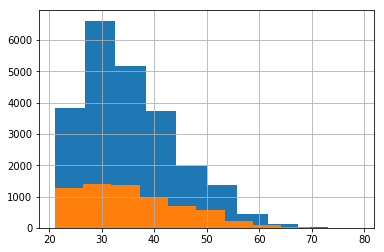

In [242]:
data_def_0['AGE'].hist()
data_def_1['AGE'].hist()

### a) гипотеза о равенстве медианных значений возрастов людей

Для сравнения медиан воспользуемся методом bootstap

In [248]:
np.random.seed(0)
data_def_0_median_scores = map(np.median, get_bootstrap_samples(data_def_0['AGE'].values, 1000))
data_def_1_median_scores = map(np.median, get_bootstrap_samples(data_def_1['AGE'].values, 1000))
delta_median_scores = map(lambda x: x[0] - x[1], zip(data_def_0_median_scores, data_def_1_median_scores))
print u"95% доверительный интервал разности медиан:",  stat_intervals(delta_median_scores, 0.05)

95% доверительный интервал разности медиан: [-1.  0.]


граница 95% интервала равна 0. Отвергнуть гипотезу равенства медиан возрастов разных групп нельзя.

### b) гипотеза о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

Воспользуемся перестановочным критерием

In [249]:
print "p-value: %f" % permutation_test(data_def_0['AGE'].values, data_def_1['AGE'].values, max_permutations = 10000)

p-value: 0.017700


P-value меньше 0.05 - значит гипотезу равенства распределений можно отвергнуть

Практически можно сделать вывод что от возраста зависит вернется кредит или нет